In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
import IPython.display as display
import time
from PIL import Image

## Uploading file manually

In [2]:
!git clone https://github.com/TaatiTeam/MotionAGFormer.git
%cd MotionAGFormer

c:\Users\devae\OneDrive\Desktop\shadow-trainer\MotionAGFormer


fatal: destination path 'MotionAGFormer' already exists and is not an empty directory.
c:\Users\devae\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

def show3Dpose(vals, ax, color='R'):
    ax.view_init(elev=15., azim=70)

    lcolor = (0, 0, 1)  # Blue
    rcolor = (1, 0, 0)  # Red
    if color == 'L':
        lcolor = (1, 1, 0)
        rcolor = (0, 1, 0)

    I = np.array([0, 0, 1, 4, 2, 5, 0, 7, 8, 8, 14, 15, 11, 12, 8, 9])
    J = np.array([1, 4, 2, 5, 3, 6, 7, 8, 14, 11, 15, 16, 12, 13, 9, 10])
    LR = np.array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0], dtype=bool)

    for i in range(len(I)):
        x, y, z = [np.array([vals[I[i], j], vals[J[i], j]]) for j in range(3)]
        ax.plot(x, y, z, lw=2, color=lcolor if LR[i] else rcolor)

    RADIUS = 0.72
    RADIUS_Z = 0.7
    xroot, yroot, zroot = vals[0, 0], vals[0, 1], vals[0, 2]
    ax.set_xlim3d([-RADIUS + xroot, RADIUS + xroot])
    ax.set_ylim3d([-RADIUS + yroot, RADIUS + yroot])
    ax.set_zlim3d([-RADIUS_Z + zroot, RADIUS_Z + zroot])
    ax.set_aspect('auto')

    white = (1.0, 1.0, 1.0, 0.0)
    ax.xaxis.set_pane_color(white)
    ax.yaxis.set_pane_color(white)
    ax.zaxis.set_pane_color(white)

    ax.tick_params('x', labelbottom=False)
    ax.tick_params('y', labelleft=False)
    ax.tick_params('z', labelleft=False)


def create_pose_video(data, output_video_path="pose_video.mp4", frame_folder="pose_frames", fps=20):
    """
    Create a 3D pose animation video from a numpy array.

    Args:
        data (np.ndarray): Shape (num_frames, num_joints, 3)
        output_video_path (str): Output path for the .mp4 video
        frame_folder (str): Temporary folder to save frames
        fps (int): Frames per second for output video
    """
    os.makedirs(frame_folder, exist_ok=True)

    for i, frame in enumerate(data):
        fig = plt.figure(figsize=(6, 6))
        gs = gridspec.GridSpec(1, 1)
        ax = plt.subplot(gs[0], projection='3d')
        show3Dpose(frame, ax)
        frame_path = os.path.join(frame_folder, f"{i:04d}.png")
        plt.savefig(frame_path, dpi=100, bbox_inches='tight')
        plt.close(fig)

    # Get video dimensions from first frame
    img = cv2.imread(os.path.join(frame_folder, "0000.png"))
    height, width, _ = img.shape
    video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for i in range(len(data)):
        img = cv2.imread(os.path.join(frame_folder, f"{i:04d}.png"))
        video.write(img)

    video.release()
    print(f"Video saved to {output_video_path}")

def create_pose_overlay_video(data1, data2, output_video_path="pose_video.mp4", frame_folder="pose_frames", fps=20):
    """
    Create a 3D pose animation video from a numpy array.

    Args:
        data1 (np.ndarray): Shape (num_frames, num_joints, 3)
        data2 (np.ndarray): Shape (num_frames, num_joints, 3)
        output_video_path (str): Output path for the .mp4 video
        frame_folder (str): Temporary folder to save frames
        fps (int): Frames per second for output video
    """
    os.makedirs(frame_folder, exist_ok=True)

    #crop video so its same length
    if len(data1) > len(data2):
        data1 = data1[:len(data2)]
    elif len(data2) > len(data1):
        data2 = data2[:len(data1)]

    for i, (frame1, frame2) in enumerate(zip(data1, data2)):
        fig = plt.figure(figsize=(6, 6))
        gs = gridspec.GridSpec(1, 1)
        ax = plt.subplot(gs[0], projection='3d')
        show3Dpose(frame1, ax)
        show3Dpose(frame2, ax, 'L')
        frame_path = os.path.join(frame_folder, f"{i:04d}.png")
        plt.savefig(frame_path, dpi=100, bbox_inches='tight')
        plt.close(fig)

    img = cv2.imread(os.path.join(frame_folder, "0000.png"))
    height, width, _ = img.shape
    video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    for i in range(len(data1)):
        img = cv2.imread(os.path.join(frame_folder, f"{i:04d}.png"))
        video.write(img)

    video.release()
    print(f"Video saved to {output_video_path}")




In [4]:
!pip install boto3

In [15]:
# prompt: create a function get_info that gets the min, max, average values from a numpy array

def get_numpy_info(arr):
  """
  Gets the minimum, maximum, and average values from a numpy array.

  Args:
    arr (np.ndarray): Input numpy array.

  Returns:
    tuple: A tuple containing (min_value, max_value, average_value).
  """

  left_ankle_arr = []
  right_ankle_arr = []
  higher_ankle_arr = []
  head_arr = []
  max_left = 0
  max_left_index = 0

  is_valid = True

  for i in range(len(arr)):
    joints = get_frame_info(arr[i])
    left_ankle_z = joints["Left Ankle"][2]
    right_ankle_z = joints["Right Ankle"][2]
    head_z = joints["Head"][2]
    if left_ankle_z > max_left:
      max_left = left_ankle_z
      max_left_index = i


    left_ankle_arr.append(left_ankle_z)
    right_ankle_arr.append(right_ankle_z)
    head_arr.append(head_z)

  #smooth the arrays
  left_ankle_arr = np.array(left_ankle_arr)
  right_ankle_arr = np.array(right_ankle_arr)
  left_ankle_arr = np.convolve(left_ankle_arr, np.ones(10)/10, mode='valid')
  right_ankle_arr = np.convolve(right_ankle_arr, np.ones(10)/10, mode='valid')

  for i in range(len(left_ankle_arr)):
    if left_ankle_arr[i] > right_ankle_arr[i]:
      higher_ankle_arr.append(1)
    else:
      higher_ankle_arr.append(0)

  #switch point is the index where the right ankle becomes higher than the left ankle after the max_left_index
  switch_point = 0
  for i in range(max_left_index, len(higher_ankle_arr)):
    if higher_ankle_arr[i] == 0:
      switch_point = i
      break
  print(f"Switch point: {switch_point}")
  #if less than 80% of the values before switch_point in higher_ankle_arr are 1 print invalid
  if np.sum(higher_ankle_arr[:switch_point]) < len(higher_ankle_arr[:switch_point])*0.8:
    is_valid = False
  #if less than 80% of the values after switch_point in higher_ankle_arr are 0 print invalid
  if np.sum(higher_ankle_arr[switch_point:]) > len(higher_ankle_arr[switch_point:])*0.2:
    is_valid = False

  if is_valid:
    print("Valid")

  #plot the joints
  # plt.plot(left_ankle_arr, label="Left Ankle")
  # plt.plot(right_ankle_arr, label="Right Ankle")
  # plt.plot(head_arr, label="Head")
  # plt.legend()
  # plt.show()

  ankle_points = [0,0,0,0]
  switch_joints = get_frame_info(arr[switch_point])
  ankle_points[0] = switch_joints["Right Ankle"][0]
  ankle_points[1] = switch_joints["Right Ankle"][1]
  ankle_points[2] = switch_joints["Left Ankle"][0]
  ankle_points[3] = switch_joints["Left Ankle"][1]
  return (is_valid, switch_point, max_left_index, ankle_points)

def get_frame_info(frame):
  joint_names = [
    "Hip", "Right Hip", "Right Knee", "Right Ankle",
    "Left Hip", "Left Knee", "Left Ankle", "Spine",
    "Thorax", "Neck", "Head", "Left Shoulder",
    "Left Elbow", "Left Wrist", "Right Shoulder",
    "Right Elbow", "Right Wrist"
    ]
  #frame is of shape 17, 3 for each joint print the x, y and z coordinates
  joints = {}
  for i in range(len(frame)):
    #print(f"{joint_names[i]}: {frame[i]}")
    joints[joint_names[i]] = frame[i]
  return joints


# Example usage:
# data = np.random.rand(10, 3)
# min_v, max_v, avg_v = get_info(data)
# print(f"Min: {min_v}, Max: {max_v}, Average: {avg_v}")


In [6]:
import numpy as np

def rotate_along_z(kpts: np.ndarray, degrees: float) -> np.ndarray:
    """
    Rotates a set of 3D keypoints around the Z-axis.

    Parameters:
        kpts (np.ndarray): Array of shape (17, 3) containing [x, y, z] keypoints.
        degrees (float): Angle in degrees to rotate around the Z-axis.

    Returns:
        np.ndarray: Rotated keypoints of shape (17, 3).
    """
    assert kpts.shape == (17, 3), "Input must be of shape (17, 3)"

    radians = np.deg2rad(degrees)
    cos_theta = np.cos(radians)
    sin_theta = np.sin(radians)

    # Rotation matrix for Z-axis
    Rz = np.array([
        [cos_theta, -sin_theta, 0],
        [sin_theta,  cos_theta, 0],
        [0,               0,    1]
    ])

    # Rotate each point
    rotated_kpts = kpts @ Rz.T  # matrix multiply (17x3) x (3x3).T = (17x3)

    return rotated_kpts


In [7]:
# prompt: Create a function that takes in 2 x,y coordinates and finds what angle they are pointing

def find_angle(coord1, coord2):
  """
  Finds the angle in degrees between the line segment connecting two 2D coordinates
  and the positive x-axis.

  Args:
    coord1 (tuple): A tuple representing the first (x, y) coordinate.
    coord2 (tuple): A tuple representing the second (x, y) coordinate.

  Returns:
    float: The angle in degrees. Returns None if the points are the same.
  """
  x1, y1 = coord1
  x2, y2 = coord2

  print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

  dx = x2 - x1
  dy = y2 - y1

  if dx == 0 and dy == 0:
    return None # Points are the same, angle is undefined

  angle = np.degrees(np.arctan2(dy, dx))
  if angle < 0:
    angle += 360
  print(f"Angle: {angle}")
  return angle

In [8]:
def resample_pose_sequence(pose_seq: np.ndarray, target_len: int) -> np.ndarray:
    """
    Resample a pose sequence to have exactly `target_len` frames using linear interpolation.

    Args:
        pose_seq (np.ndarray): Input array of shape (n, 17, 3), where n is the number of frames.
        target_len (int): Desired number of output frames.

    Returns:
        np.ndarray: Resampled array of shape (target_len, 17, 3)
    """
    n_frames, n_joints, n_dims = pose_seq.shape
    if n_frames == target_len:
        return pose_seq.copy()

    # Create an array of indices for the original and target frame positions
    original_indices = np.linspace(0, n_frames - 1, num=n_frames)
    target_indices = np.linspace(0, n_frames - 1, num=target_len)

    # Interpolate along the time axis for each joint and dimension
    resampled = np.zeros((target_len, n_joints, n_dims), dtype=np.float32)
    for j in range(n_joints):
        for d in range(n_dims):
            resampled[:, j, d] = np.interp(target_indices, original_indices, pose_seq[:, j, d])

    return resampled

In [9]:
def shift_data_time(data, switch, max_y, time_1=100, time_2=100, time_3=100):
    segment_1 = data[:max_y,:,:]
    segment_2 = data[max_y: switch,:,:]
    segment_3 = data[switch:,:,:]
    segment_1 = resample_pose_sequence(segment_1, time_1)
    segment_2 = resample_pose_sequence(segment_2, time_2)
    segment_3 = resample_pose_sequence(segment_3, time_3)
    final_arr = np.concatenate([segment_1,segment_2,segment_3], axis=0)
    print(final_arr.shape)
    return final_arr


In [ ]:
import boto3
import tempfile
def list_and_play_mp4_from_s3(bucket_name, prefix, aws_access_key_id=None, aws_secret_access_key=None, region_name='us-east-2'):
    if aws_access_key_id and aws_secret_access_key:
        s3 = boto3.client(
            's3',
            aws_access_key_id=aws_access_key_id,
            aws_secret_access_key=aws_secret_access_key,
            region_name=region_name
        )
    else:
        s3 = boto3.client('s3')

    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket_name, Prefix=prefix)
    cleaned_list = []
    count = 0
    val_list = []
    prev_frames = None
    for page in pages:
        if 'Contents' in page:
            for obj in page['Contents']:
                key = obj['Key']
                if key.endswith('.npy'):
                    print(f"\n[INFO] Processing: {key}")

                    with tempfile.NamedTemporaryFile(delete=False, suffix=".npy") as temp_file:
                        temp_path = temp_file.name
                    count += 1
                    if count == 10:
                        break
                    try:
                        s3.download_file(bucket_name, key, temp_path)
                        data = np.load(temp_path)
                        print(data.shape)
                        valid, switch_point, max_y_pt, ankle_points = get_numpy_info(data)
                        angle = find_angle(ankle_points[0:2], ankle_points[2:4])
                        val_list.append(valid)
                        base_name = os.path.splitext(os.path.basename(key))[0]
                        output_video_path = f"{base_name}_pose_video.mp4"
                        if val_list[-1]:
                            for i in range(len(data)):
                                data[i] = rotate_along_z(data[i], 135 - angle)
                            data = shift_data_time(data, switch_point, max_y_pt)
                            cleaned_list.append(data)
                            if prev_frames is not None:
                                create_pose_overlay_video(prev_frames, data, output_video_path=output_video_path)
                                print(next)
                            prev_frames = resample_pose_sequence(data, 300)

                    except:
                        print("FAILED")
    print(val_list)
    print(np.sum(val_list)/len(val_list))
    return cleaned_list


cleaned_list = list_and_play_mp4_from_s3('shadow-trainer-dev', 'pose_numpy/BieberShaneR','','')



[INFO] Processing: pose_numpy/BieberShaneR/FF/cropped_03587bf2-48bb-45f5-84b5-38eec993695e_0.npy
(137, 17, 3)
Switch point: 68
Valid
x1: 0.17914997041225433, y1: 0.15817737579345703, x2: -0.2848067581653595, y2: 0.2602338492870331
Angle: 167.59422302246094
(300, 17, 3)

[INFO] Processing: pose_numpy/BieberShaneR/FF/cropped_056e8a41-26e8-4e07-8ba0-9e0c90a882d3_0.npy
(155, 17, 3)
Switch point: 85
Valid
x1: 0.1717153787612915, y1: 0.15046514570713043, x2: -0.2874290943145752, y2: 0.1581716239452362
Angle: 179.0384063720703
(300, 17, 3)
Video saved to cropped_056e8a41-26e8-4e07-8ba0-9e0c90a882d3_0_pose_video.mp4
<built-in function next>

[INFO] Processing: pose_numpy/BieberShaneR/FF/cropped_06b5a393-a563-4c27-83a1-d975f8360624_1.npy
(150, 17, 3)
Switch point: 83
Valid
x1: 0.17838571965694427, y1: 0.14181144535541534, x2: -0.2875988185405731, y2: 0.19569051265716553
Angle: 173.40451049804688
(300, 17, 3)
Video saved to cropped_06b5a393-a563-4c27-83a1-d975f8360624_1_pose_video.mp4
<built-in

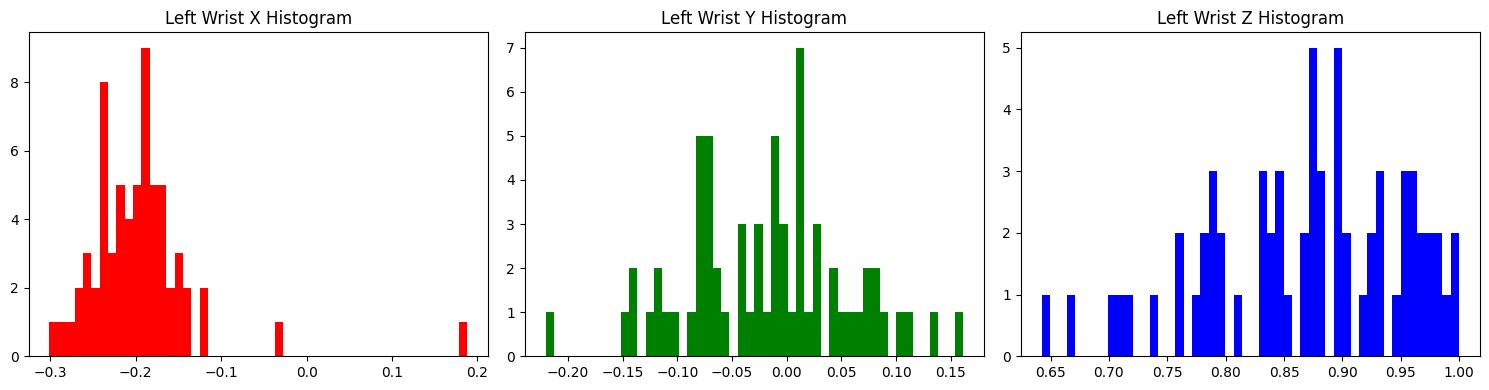

In [53]:
import numpy as np
import matplotlib.pyplot as plt

joint_names = [
    "Hip", "Right Hip", "Right Knee", "Right Ankle",
    "Left Hip", "Left Knee", "Left Ankle", "Spine",
    "Thorax", "Neck", "Head", "Left Shoulder",
    "Left Elbow", "Left Wrist", "Right Shoulder",
    "Right Elbow", "Right Wrist"
]

LEFT_WRIST_INDEX = joint_names.index("Right Wrist")

# Assuming cleaned_list is a list of arrays with shape (frames, 17, 3)
x_vals, y_vals, z_vals = [], [], []

for seq in cleaned_list:
    # Get all frames of Left Wrist joint
    lwrist_coords = seq[225:226, LEFT_WRIST_INDEX, :]  # shape: (frames, 3)
    x_vals.extend(lwrist_coords[:, 0])
    y_vals.extend(lwrist_coords[:, 1])
    z_vals.extend(lwrist_coords[:, 2])

# Convert to numpy arrays for histogram
x_vals, y_vals, z_vals = map(np.array, (x_vals, y_vals, z_vals))

# Plot histograms
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.hist(x_vals, bins=50, color='red')
plt.title('Left Wrist X Histogram')

plt.subplot(1, 3, 2)
plt.hist(y_vals, bins=50, color='green')
plt.title('Left Wrist Y Histogram')

plt.subplot(1, 3, 3)
plt.hist(z_vals, bins=50, color='blue')
plt.title('Left Wrist Z Histogram')

plt.tight_layout()
plt.show()


In [54]:
joint_names = [
    "Hip", "Right Hip", "Right Knee", "Right Ankle",
    "Left Hip", "Left Knee", "Left Ankle", "Spine",
    "Thorax", "Neck", "Head", "Left Shoulder",
    "Left Elbow", "Left Wrist", "Right Shoulder",
    "Right Elbow", "Right Wrist"
    ]

print(len(cleaned_list))
for i in cleaned_list:
    print(i.shape)
    for j in range(len(i[250])):
        print(joint_names[j], i[250][j])



65
(300, 17, 3)
Hip [0.        0.        0.6499284]
Right Hip [-0.0509112   0.04675456  0.6840443 ]
Right Knee [-0.11555647  0.28784183  0.46995324]
Right Ankle [-0.2402551   0.25585753  0.71252453]
Left Hip [ 0.09652434 -0.01778918  0.6306262 ]
Left Knee [0.07927526 0.05065488 0.28316557]
Left Ankle [0.10055646 0.12341988 0.        ]
Spine [ 0.08261832 -0.03464498  0.7762428 ]
Thorax [ 0.14351399 -0.19624995  0.89581925]
Neck [ 0.10654896 -0.2564533   0.92640966]
Head [ 0.11004415 -0.2653094   1.        ]
Left Shoulder [ 0.20588803 -0.20487906  0.84246963]
Left Elbow [ 0.20845228 -0.10400017  0.67423403]
Left Wrist [ 0.14152445 -0.24260837  0.6609532 ]
Right Shoulder [ 0.04197256 -0.12886661  0.8893643 ]
Right Elbow [-0.06445504 -0.16759963  0.7163226 ]
Right Wrist [ 0.02919975 -0.3282479   0.70377296]
(300, 17, 3)
Hip [0.        0.        0.6462859]
Right Hip [-0.05952107  0.05174047  0.669827  ]
Right Knee [-0.06841449  0.28588286  0.44046858]
Right Ankle [-0.15637213  0.29707778  0

In [55]:
stacked = np.stack(cleaned_list, axis=0)

# Compute the average across the first axis
average_array = np.median(cleaned_list, axis=0)
print(average_array.shape)
create_pose_video(average_array, "average.mp4", "pose_frames", fps=30)

(300, 17, 3)
Video saved to average.mp4


In [56]:
!pwd
!ls

'pwd' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.
